# CNN Multi Class Classification and Computer Vision

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile

## Data generation

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip


--2024-08-02 13:26:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.199.207, 74.125.195.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   173MB/s    in 2.9s    

2024-08-02 13:26:49 (173 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [5]:
!ls

10_food_classes_all_data.zip  sample_data


In [6]:
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [7]:
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.

In [8]:
!ls 10_food_classes_all_data/

test  train


In [9]:
train_data_dir = "10_food_classes_all_data/train/"
test_data_dir = "10_food_classes_all_data/test/"

In [10]:
import pathlib

data_dir = pathlib.Path(train_data_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [15]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img

Image class: pizza
Image shape: (512, 512, 3)
Image class: ice_cream
Image shape: (384, 512, 3)
Image class: hamburger
Image shape: (512, 512, 3)
Image class: hamburger
Image shape: (512, 512, 3)
Image class: sushi
Image shape: (512, 512, 3)
Image class: sushi
Image shape: (512, 512, 3)
Image class: ramen
Image shape: (512, 512, 3)
Image class: pizza
Image shape: (512, 512, 3)
Image class: hamburger
Image shape: (512, 512, 3)
Image class: sushi
Image shape: (512, 512, 3)


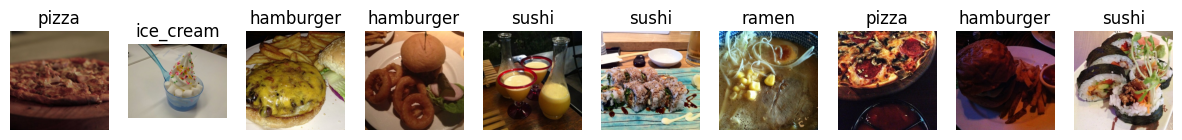

In [22]:
plt.figure(figsize=(15, 15))
for i in range(10):
  random_class = random.choice(class_names)
  print(f"Image class: {random_class}")
  plt.subplot(1, 10, i+1)
  view_random_image(train_data_dir, random_class)

## Data Preprocessing

In [28]:
train_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.)


train_data = train_data_gen.flow_from_directory(train_data_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode="categorical")

test_data = test_data_gen.flow_from_directory(test_data_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode="categorical")

len(train_data), len(test_data)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


(235, 79)

In [31]:
train_data.class_indices, test_data.class_indices

({'chicken_curry': 0,
  'chicken_wings': 1,
  'fried_rice': 2,
  'grilled_salmon': 3,
  'hamburger': 4,
  'ice_cream': 5,
  'pizza': 6,
  'ramen': 7,
  'steak': 8,
  'sushi': 9},
 {'chicken_curry': 0,
  'chicken_wings': 1,
  'fried_rice': 2,
  'grilled_salmon': 3,
  'hamburger': 4,
  'ice_cream': 5,
  'pizza': 6,
  'ramen': 7,
  'steak': 8,
  'sushi': 9})

In [33]:
train_data.image_shape, test_data.image_shape

((224, 224, 3), (224, 224, 3))

In [35]:
train_data[0][0].shape, train_data[0][1].shape

((32, 224, 224, 3), (32, 10))

In [37]:
train_data[0][0][0], train_data[0][1][0]

(array([[[0.9725491 , 1.        , 0.9921569 ],
         [0.98823535, 1.        , 0.9921569 ],
         [0.9960785 , 0.9921569 , 0.9843138 ],
         ...,
         [1.        , 1.        , 0.9921569 ],
         [1.        , 0.9921569 , 0.9960785 ],
         [1.        , 0.9921569 , 1.        ]],
 
        [[0.9803922 , 1.        , 0.9843138 ],
         [0.86274517, 0.8431373 , 0.8313726 ],
         [0.6901961 , 0.63529414, 0.6313726 ],
         ...,
         [0.64705884, 0.6431373 , 0.63529414],
         [0.83921576, 0.8313726 , 0.8352942 ],
         [1.        , 0.9921569 , 0.9960785 ]],
 
        [[0.9686275 , 0.96470594, 0.9490197 ],
         [0.69803923, 0.6431373 , 0.6313726 ],
         [0.17254902, 0.09019608, 0.07058824],
         ...,
         [0.10588236, 0.09019608, 0.07843138],
         [0.5764706 , 0.57254905, 0.5647059 ],
         [0.9921569 , 0.9921569 , 0.9843138 ]],
 
        ...,
 
        [[1.        , 1.        , 0.9921569 ],
         [0.9568628 , 0.95294124, 0.94509

## Model Experiments

In [39]:
tf.random.set_seed(42);

model_1 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(10, activation='softmax')
])



model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=['accuracy'])


model_1_history = model_1.fit(train_data,
          epochs=5,
          # steps_per_epoch=len(train_data),
          validation_data=test_data,
          # validation_steps=len(test_data)
          )

model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.1677 - loss: 2.2530 - val_accuracy: 0.3064 - val_loss: 1.9932
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 35s 148ms/step - accuracy: 0.3250 - loss: 1.9324 - val_accuracy: 0.3524 - val_loss: 1.8625
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.4522 - loss: 1.6611 - val_accuracy: 0.3352 - val_loss: 1.9153
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.6085 - loss: 1.2191 - val_accuracy: 0.3224 - val_loss: 2.2641
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - accuracy: 0.8320 - loss: 0.5572 - val_accuracy: 0.3016 - val_loss: 2.8377


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 110, 110, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 108, 108, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 106, 106, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 53, 53, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 28090)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │         280,910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 851,762 (3.25 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 567,842 (2.17 MB)

In [45]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(15,15))
  plt.subplot(2, 2, 1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

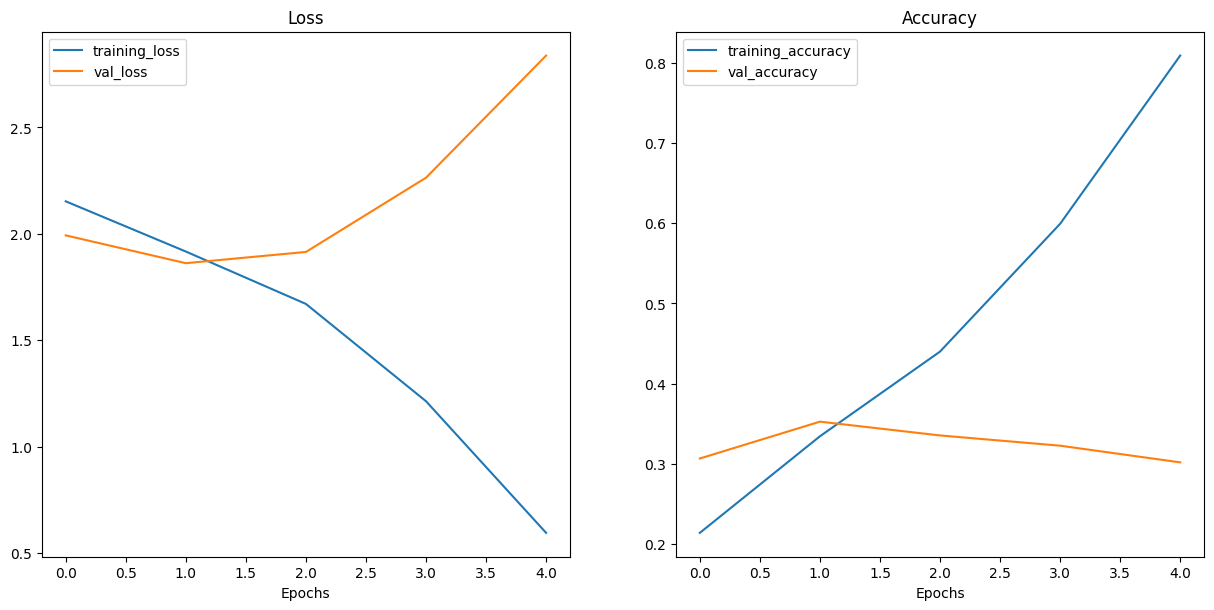

In [46]:
plot_loss_curves(model_1_history)
# model_1_history.history

In [47]:
tf.random.set_seed(42)


model_2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(10, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(10, activation='softmax')
])


model_2.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])


model_2_history = model_2.fit(train_data,
          epochs=5,
          # steps_per_epoch=len(train_data),
          validation_data=test_data,
          # validation_steps=len(test_data)
          );

model_2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 32s 119ms/step - accuracy: 0.1885 - loss: 2.1873 - val_accuracy: 0.2884 - val_loss: 1.9517
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - accuracy: 0.3419 - loss: 1.8965 - val_accuracy: 0.3280 - val_loss: 1.8869
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.4210 - loss: 1.7289 - val_accuracy: 0.3624 - val_loss: 1.8460
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 107ms/step - accuracy: 0.4682 - loss: 1.5910 - val_accuracy: 0.3752 - val_loss: 1.8041
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - accuracy: 0.5440 - loss: 1.3786 - val_accuracy: 0.3732 - val_loss: 1.9101


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 111, 111, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 109, 109, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 54, 54, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 52, 52, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 26, 26, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          67,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,132 (816.93 KB)

 Trainable params: 69,710 (272.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 139,422 (544.62 KB)

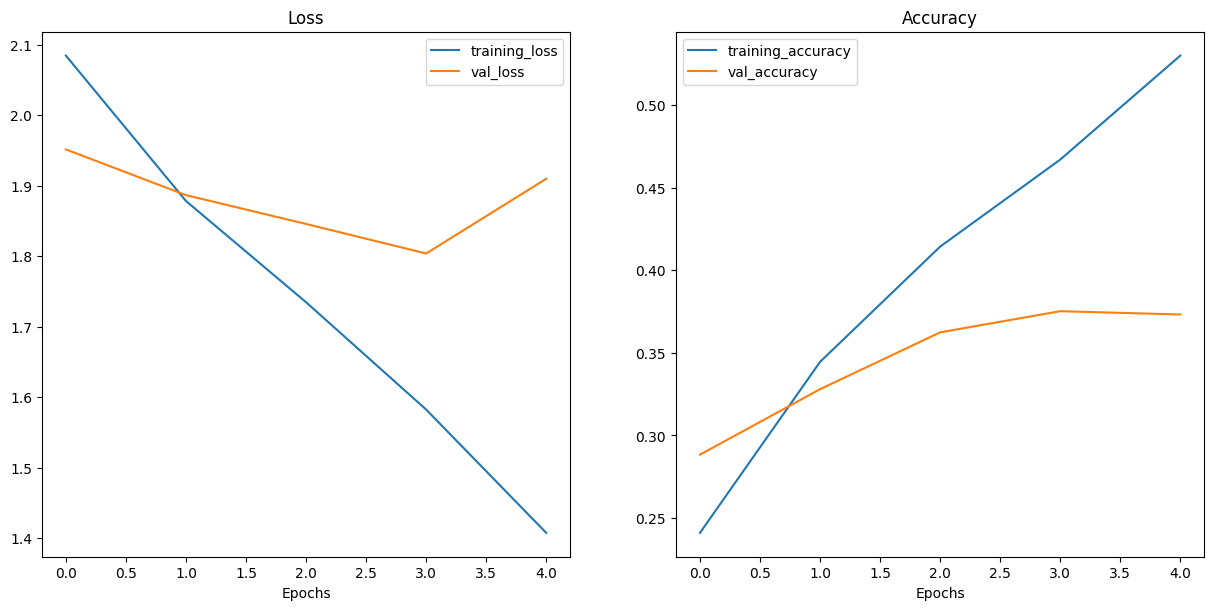

In [48]:
plot_loss_curves(model_2_history)

## Model Experiments with Data Augmentation

In [49]:
train_data_gen_aug = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_data_gen_aug = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


train_data_aug = train_data_gen_aug.flow_from_directory(train_data_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode="categorical")

test_data_aug = test_data_gen_aug.flow_from_directory(test_data_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [50]:
len(train_data_aug), len(test_data_aug  )

(235, 79)

In [51]:
train_data_aug[0][0].shape, train_data_aug[0][1].shape

((32, 224, 224, 3), (32, 10))

In [ ]:
# batch size 32 , image shape 224,224,3
# output have 10 classes

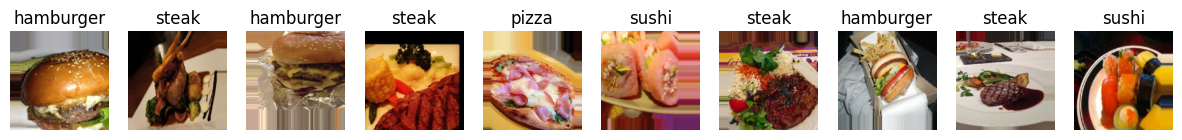

In [68]:
plt.figure(figsize=(15,15))

for i in range(10):

  plt.subplot(1, 10, i+1)
  idx1 = random.randint(0, len(train_data_aug)-1)
  idx2 = random.randint(0, 31) # batch size is 32 and that is why static 31 have been set

  random_image = train_data_aug[idx1][0][idx2]
  random_label = train_data_aug[idx1][1][idx2]

  # print(random_image.shape)
  # print(random_label)
  # plt.figure()
  plt.imshow(random_image)
  plt.title(class_names[np.argmax(random_label)])
  plt.axis("off");
  # plt.show()


In [69]:
tf.random.set_seed(42)


model_3 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Conv2D(10,3, activation='relu'),
    MaxPooling2D(),
    Conv2D(10,3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(10, activation='softmax')
])


model_3.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])


model_3_history = model_3.fit(train_data_aug,
          epochs=5,
          # steps_per_epoch=len(train_data),
          validation_data=test_data_aug,
          # validation_steps=len(test
)


model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 126s 513ms/step - accuracy: 0.1668 - loss: 2.2328 - val_accuracy: 0.2632 - val_loss: 2.0435
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 138s 500ms/step - accuracy: 0.2670 - loss: 2.0686 - val_accuracy: 0.2936 - val_loss: 2.0096
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 120s 501ms/step - accuracy: 0.2922 - loss: 2.0021 - val_accuracy: 0.3144 - val_loss: 1.9553
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 120s 499ms/step - accuracy: 0.3184 - loss: 1.9648 - val_accuracy: 0.3180 - val_loss: 1.9392
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 153s 551ms/step - accuracy: 0.3172 - loss: 1.9445 - val_accuracy: 0.3576 - val_loss: 1.8528


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 111, 111, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 109, 109, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 54, 54, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 52, 52, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 26, 26, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          67,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,132 (816.93 KB)

 Trainable params: 69,710 (272.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 139,422 (544.62 KB)

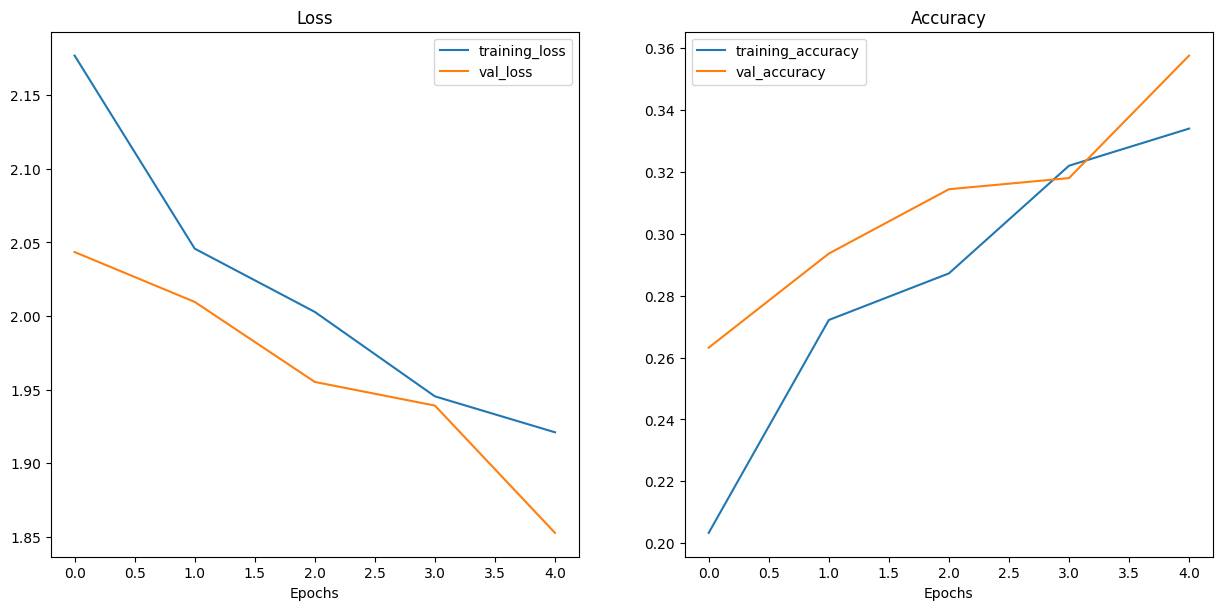

In [70]:
plot_loss_curves(model_3_history)

In [ ]:
tf.random.set_seed(42)

model_4 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Conv2D(10,3, activation='relu'),
    # MaxPooling2D(),
    Conv2D(10,3, activation='relu'),
    # MaxPooling2D(),
    Conv2D(10,3, activation='relu'),
    MaxPooling2D(),
    Conv2D(10,3, activation='relu'),
    MaxPooling2D(),
    Conv2D(10,3, activation='relu'),
    # Conv2D(10,3, activation='relu'),
    # Conv2D(10,3, activation='relu'),
    # Conv2D(10,3, activation='relu'),
    # Conv2D(10,3, activation='relu'),
    # Conv2D(10,3, activation='relu'),
    # MaxPooling2D(),
    # Conv2D(10,3, activation='relu'),
    # MaxPooling2D(),
    # Conv2D(10,3, activation='relu'),
    # MaxPooling2D(),
    # Conv2D(10,3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(10, activation='softmax')
])


model_4.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])


model_4_history = model_4.fit(
    train_data_aug,
          epochs=5,
          # steps_per_epoch=len(train_data),
          validation_data=test_data_aug,
          # validation_steps=len(test
)


model_4.summary()

Epoch 1/5
146/235 ━━━━━━━━━━━━━━━━━━━━ 35s 400ms/step - accuracy: 0.1119 - loss: 2.3000

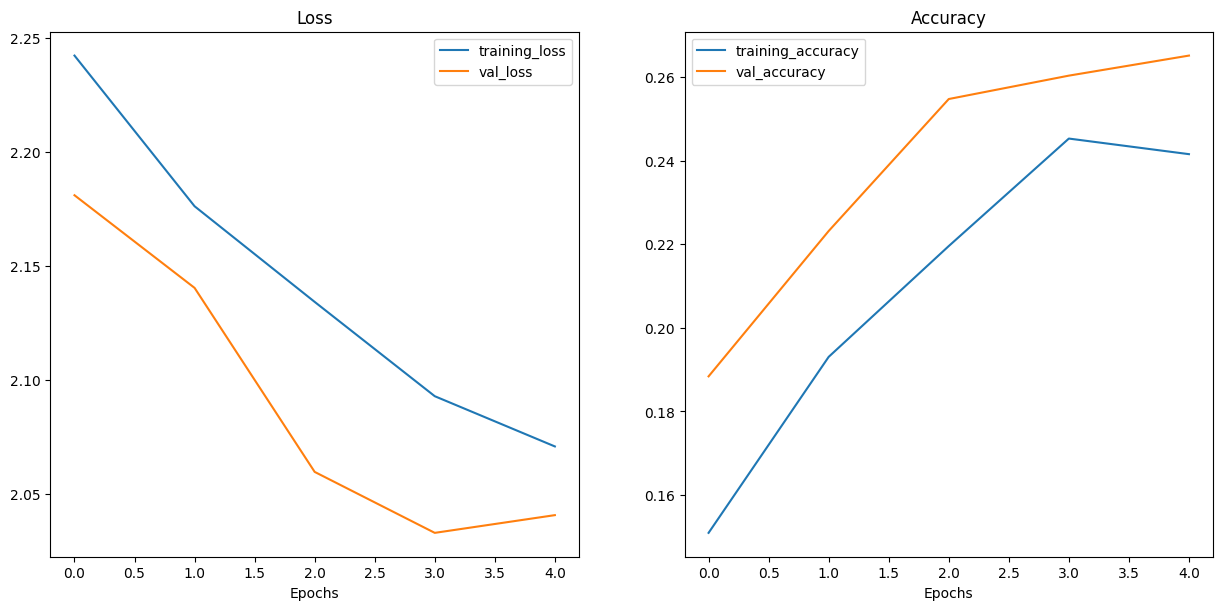

In [90]:
plot_loss_curves(model_4_history)

((32, 224, 224, 3), (32, 10))